In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_complex_values(sd, size):
    # Générer un vecteur aléatoire complexe avec une distribution gaussienne
    real_part = np.random.normal(0, sd, size)
    imag_part = np.random.normal(0, sd, size)

    # Créer un tableau complexe à partir des parties réelle et imaginaire
    complex_values = np.vectorize(complex)(real_part, imag_part)

    return complex_values

def generate_steering_vector(L, theta, d = 1, wavelength = 2):
    # Génération du steering vector
    steering_vector = np.exp(-1j * np.arange(L) * 2 * np.pi * d / wavelength * np.sin(np.radians(theta)))
    return steering_vector

# Paramètres
M = 2 # Nombre de sources
L = 10 # Nombre de capreurs
T = 100 # Nombre de points temporels
theta1 = 30 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = -50 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2


# Générer la matrice S
S = []
for _ in range(M):
    S_t = generate_complex_values(1, T)
    S.append(S_t)
S = np.transpose(np.array(S))

# Générer la steering matrix à deux sources
A_1 = generate_steering_vector(L, theta1)
A_2 = generate_steering_vector(L, theta2)
A = np.transpose(np.array([A_1, A_2]))

# Générer la matrice X
X = []
for i in range(T):
    b_t = generate_complex_values(1, L)
    X_t = np.dot(A, S[i]) + b_t
    X.append(X_t)
X = np.array(X)


[-49.6  29.6]


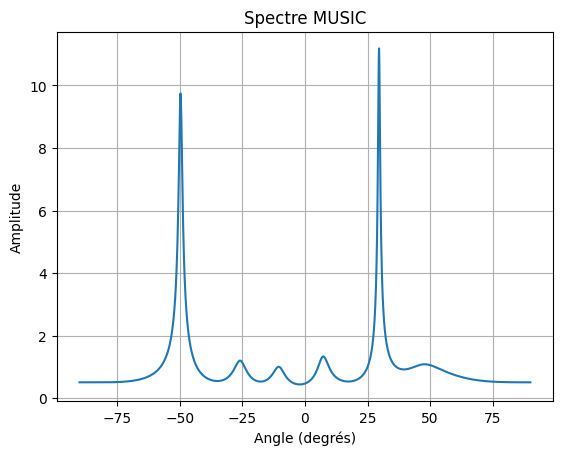

In [2]:
#ALGORITMHE MUSIC

# Calcul de la matrice de covariance
R_hat = np.cov(X, rowvar=False)

# Calculer les vecteurs propres et les valeurs propres
eigenvalues, eigenvectors = np.linalg.eigh(R_hat)

# Sélectionner les k plus grandes valeurs propres
noise_subspace = eigenvectors[:, :M]

# Liste des angles pour lesquels on souhaite estimer la provenance
theta_range = np.linspace(-90, 90, 1801)

# Calcul du spectre MUSIC
music_spectrum = np.zeros_like(theta_range, dtype=float)
for idx, theta in enumerate(theta_range):
    steering_vector = generate_steering_vector(L, theta)
    music_spectrum[idx] = 1 / np.linalg.norm(noise_subspace.conj().T @ steering_vector)


# Recherche des peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(music_spectrum, height=4)  # height correpond à un treshhold ajustable
estimated_angles = theta_range[peaks]

print(estimated_angles)


# Visualiser le spectre MUSIC
plt.plot(theta_range, np.real(music_spectrum))
plt.title('Spectre MUSIC')
plt.xlabel('Angle (degrés)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CovarianceDataset(Dataset):
    def __init__(self, covariance_matrices, doa_labels):
        self.covariance_matrices = covariance_matrices
        self.doa_labels = doa_labels

    def __len__(self):
        return len(self.covariance_matrices)

    def __getitem__(self, idx):
        covariance_matrix = self.covariance_matrices[idx]
        doa_label = self.doa_labels[idx]

        # Aplatir la matrice de covariance pour le réseau de neurones
        covariance_matrix = covariance_matrix.flatten()

        # Convertir en tenseurs PyTorch
        covariance_matrix = torch.from_numpy(covariance_matrix).float()
        doa_label = torch.tensor(doa_label).float()

        return covariance_matrix, doa_label




# Exemple d'utilisation
# spectra = np.load('chemin_vers_votre_fichier_spectra.npy')
# labels = np.load('chemin_vers_votre_fichier_labels.npy')



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DOAModel(nn.Module):
    def __init__(self):
        super(DOAModel, self).__init__()
        self.fc1 = nn.Linear(100, 512)  # Adapté à la taille aplatie de la matrice de covariance
        # Ajouter d'autres couches selon les besoins
        self.fc2 = nn.Linear(512, 1)    # Couche de sortie pour la régression DOA

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Pas d'activation ReLU pour la couche de sortie de la régression
        return x


In [5]:
from sklearn.model_selection import train_test_split

spectra_train, spectra_test, labels_train, labels_test = train_test_split(music_spectrum, theta_range, test_size=0.2, random_state=42)

train_dataset = MusicSpectrumDataset(spectra_train, labels_train)
test_dataset = MusicSpectrumDataset(spectra_test, labels_test)

train_dataset = MusicSpectrumDataset(spectra_train, theta_range)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = MusicSpectrumDataset(spectra_test, theta_range)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)



NameError: name 'MusicSpectrumDataset' is not defined

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Calculer la prédiction et la perte
        pred = model(X)
        loss = loss_fn(pred, y)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Rétropropagation
        loss.backward()

        # Optimisation
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

model = DOAEstimator().to(device)


In [ ]:
train_dataset = MusicSpectrumDataset(spectra_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
# Exemple d'utilisation
model = DOAEstimator().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    eval_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 1801x1024)

In [ ]:
for  batch (X, y) in enumrate(dataloader):
    print(X.)

In [62]:
# Juste avant de créer le Dataset
for i in range(5):  # Imprimer les formes des 5 premiers éléments
    print(music_spectrum[i].shape)

()
()
()
()
()


In [63]:
music_spectrum

array([0.55011584, 0.55011388, 0.550108  , ..., 0.55012369, 0.5501178 ,
       0.55011584])